### Submission for Statistical Methods for Experimental Physics Assessment 2 - Mihir Koka

##### 1.1 The Calorimeter Resolution

Importing packages we will be using

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm
from iminuit import minimize
from scipy.interpolate import interp1d

plt.rcParams.update({'font.size': 10})

##### (i) [1 mark] For each e_true value draw a histogram of e_diff = e_measured - e_true

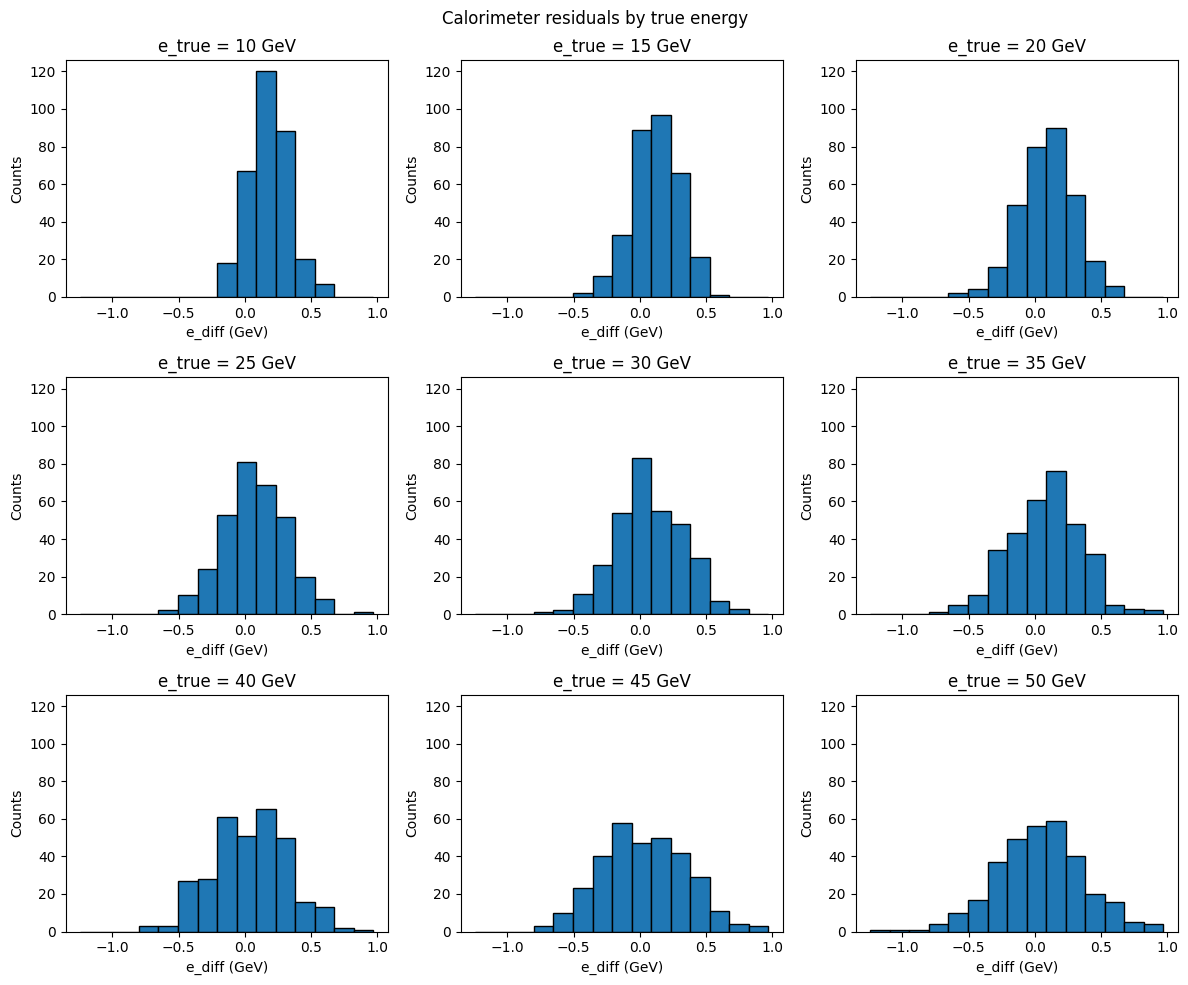

In [24]:
df_data = pd.read_csv('data_calorimeter.csv') #this is in the same directory as the notebook
df_data['e_diff'] = df_data['e_measured'] - df_data['e_true']

energies = sorted(df_data['e_true'].unique()) #could just hardcode them as we know what they are, but this is a nicer way
bins = np.linspace(df_data['e_diff'].min(), df_data['e_diff'].max(), 16)

fig,axes = plt.subplots(3,3, figsize=(12,10), sharex=True, sharey=True) #make a 3x3 grid for all 9 plots we need
for ax, E in zip(axes.flat, energies):
    diffs = df_data.loc[df_data['e_true'] == E, 'e_diff']
    ax.hist(diffs, bins=bins, color='C0', edgecolor='black')
    ax.set_title(f"e_true = {E} GeV")
    ax.set_xlabel("e_diff (GeV)")
    ax.set_ylabel("Counts")
    ax.tick_params(labelbottom=True, labelleft=True)

    

fig.suptitle("Calorimeter residuals by true energy")
plt.tight_layout()
plt.show()


##### (ii) [2 marks] We can assume that due to the resolution of calorimeter, e_diff will be distributed as a Gaussian distribution.... For each value of e_true find the MLE mu and sigma.

So inital thoughts are that we could do this in a closed-form/analytical way. This is because for a Gaussian, MLEs are the sample mean and the population s.d

$ \hat{\mu}$ = mean(e_diff) \
$ \hat{\sigma}$ = sqrt(mean((e_diff - u_hat)^2)) \
so we wouldn't need an optimizer, but given the question suggests doing it numerically let's proceed with that.

- Assumption: For each e_true, the residuals e_diff follow a Gaussian with mean μ and width σ.
- We perform an unbinned numerical MLE by minimizing the negative log-likelihood:
  NLL(μ, σ) = 0.5 * Σ_i [ ((x_i − μ)/σ)^2 + ln(2πσ^2) ], with σ > 0.
- For each e_true, initialize μ at the sample mean and σ at the sample std, then minimize using SciPy.

In [25]:
# 1.1 (ii) – Numerical MLE (Gaussian) per e_true using SciPy

from scipy.optimize import minimize as opt_minimize

#negative log-likelihood function for Gaussian
def nll_gauss(theta, x):
    mu, sigma = theta
    return 0.5 * np.sum(((x - mu) / sigma) ** 2 + np.log(2 * np.pi * sigma ** 2))

energies = sorted(df_data['e_true'].unique())
rows = []

for E in energies:
    x = df_data.loc[df_data['e_true'] == E, 'e_diff'].values #just like in part (i)
    mu0 = x.mean()
    sig0 = x.std(ddof=0) if x.std(ddof=0) > 0 else 1e-3 #keeping our sigma > 0, else we get issues when minimizing
    #ddof = 0 b/c we're dividing by N not N-1 for sample variance
    res = opt_minimize(
        nll_gauss,
        x0=np.array([mu0, sig0]),
        args=(x,),
        method='L-BFGS-B',
        bounds=[(None, None), (1e-6, None)]
    )
    mu_hat, sigma_hat = res.x
    rows.append({'e_true': E, 'mu_hat': mu_hat, 'sigma_hat': sigma_hat})

summary_mle = pd.DataFrame(rows).sort_values('e_true')
print(summary_mle.round(6).to_string(index=False))

 e_true   mu_hat  sigma_hat
     10 0.181922   0.151432
     15 0.120331   0.176225
     20 0.094020   0.204680
     25 0.075402   0.235988
     30 0.068854   0.250193
     35 0.083918   0.265224
     40 0.037715   0.284078
     45 0.028788   0.316492
     50 0.041381   0.337155


so we see our u_hat is small and remains positive across all the energies. Further our sigma_hat grows with energy, which makes sense.

##### (iii) [2 marks] Plot our Gaussian from the previous parts on top of the histograms. Also plot the ratio of the MLE to the value of e_true

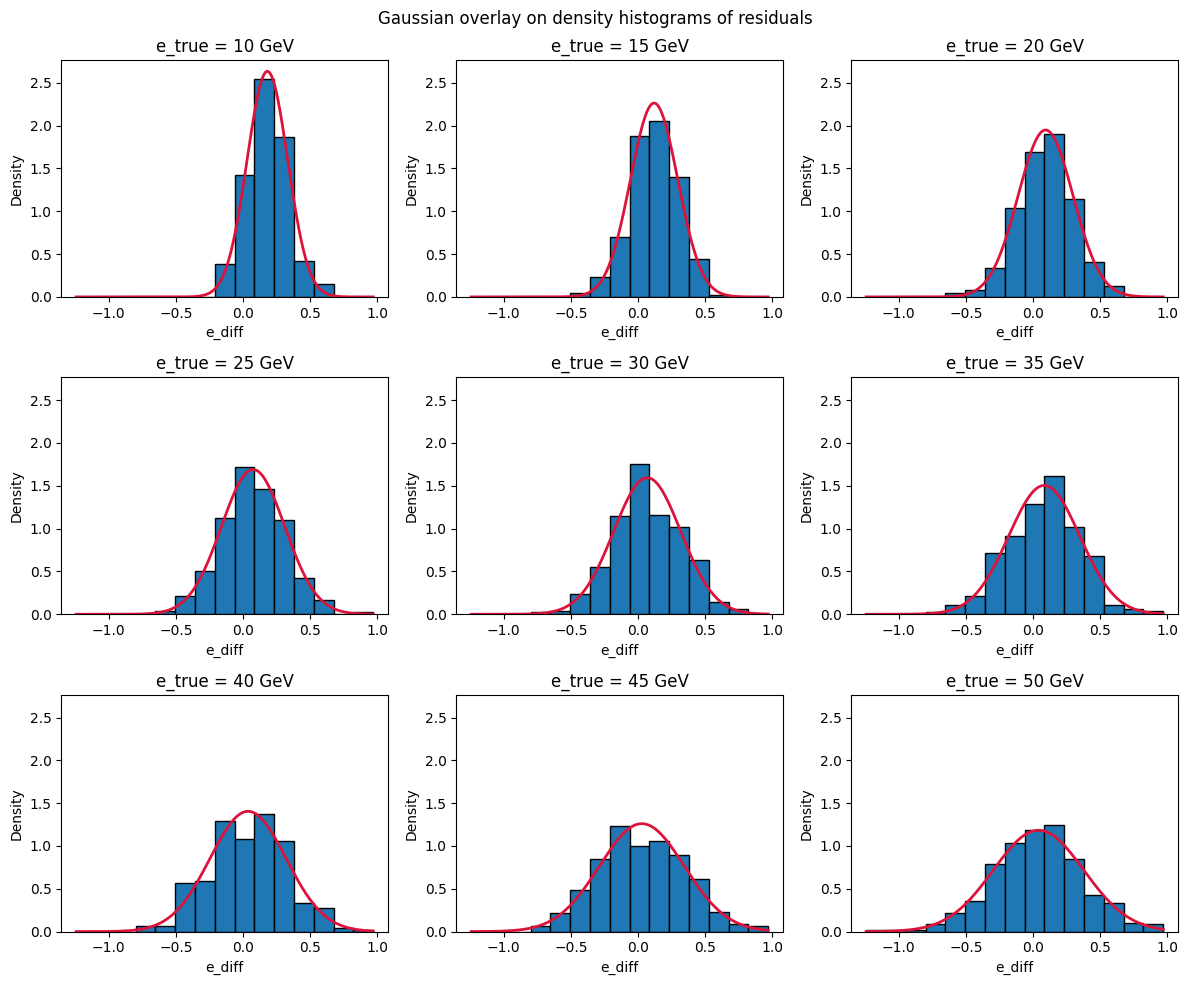

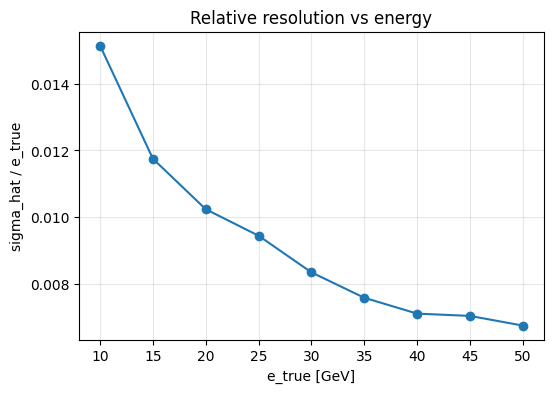

In [ ]:
# 1.1 (iii) – overlay Gaussian on density histograms + plot sigma_hat / e_true

# Overlay on density histograms
energies = sorted(df_data['e_true'].unique())
bins = np.linspace(df_data['e_diff'].min(), df_data['e_diff'].max(), 16)

fig, axes = plt.subplots(3, 3, figsize=(12, 10), sharex=True, sharey=True)
for ax, E in zip(axes.flat, energies):
    diffs = df_data.loc[df_data['e_true'] == E, 'e_diff'].values
    # Get the MLEs for this energy
    row = summary_mle.loc[summary_mle['e_true'] == E].iloc[0]
    mu, sigma = row['mu_hat'], row['sigma_hat']

    # Density histogram
    ax.hist(diffs, bins=bins, density=True, edgecolor='black')

    # Gaussian PDF overlay (density)
    x = np.linspace(bins[0], bins[-1], 400)
    y = norm.pdf(x, loc=mu, scale=sigma)
    ax.plot(x, y, color='crimson', lw=2)

    ax.set_title(f"e_true = {E} GeV")
    ax.set_xlabel("e_diff")
    ax.set_ylabel("Density")
    ax.tick_params(labelbottom=True, labelleft=True)


fig.suptitle("Gaussian overlay on density histograms of residuals")
plt.tight_layout()
plt.show()

# Plot sigma_hat / e_true
plt.figure(figsize=(6,4))
plt.plot(summary_mle['e_true'], summary_mle['sigma_hat'] / summary_mle['e_true'], 'o-')
plt.xlabel("e_true [GeV]")
plt.ylabel("sigma_hat / e_true")
plt.title("Relative resolution vs energy")
plt.grid(True, alpha=0.3)
plt.show()